# Analizy eksploracyjna (EDA)

In [1]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from nltk.corpus import stopwords
import numpy as np
import nltk

sys.path.append(os.path.abspath("../../"))
from src.utils import load_dataset

In [2]:
df = load_dataset("data/processed_data/dataset.pkl")

2025-04-07 22:02:54 - INFO - Loading dataset


### Analiza typów danych

### Dane kategoryczne oraz numeryczne

In [3]:
cath_cols = [
    "limited_edition",
    "new",
    "online_only",
    "out_of_stock",
    "sephora_exclusive",
    "contains_refund",
]
num_cols = df.select_dtypes(include=["float64", "int64"]).columns.values
num_cols = [col for col in num_cols if col not in cath_cols]

- **ile znajduje się w zbiorze cech kategorycznych, a ile numerycznych?**

Cech kategorycznych: 6

Cech numerycznych: 17

In [4]:
print(f"Cech kategorycznych: {len(cath_cols)}")
print(f"Cech numerycznych: {len(num_cols)}")

print(f"Kategoryczne: {cath_cols}")
print(f"Numeryczne: {num_cols}")

Cech kategorycznych: 6
Cech numerycznych: 17
Kategoryczne: ['limited_edition', 'new', 'online_only', 'out_of_stock', 'sephora_exclusive', 'contains_refund']
Numeryczne: ['LABEL-rating', 'helpfulness', 'total_feedback_count', 'total_neg_feedback_count', 'total_pos_feedback_count', 'price_usd', 'loves_count', 'rating', 'reviews', 'value_price_usd', 'sale_price_usd', 'child_count', 'child_max_price', 'child_min_price', 'review_length', 'exclamation_count', 'unique_word_count']


- **czy zmienna wyjściowa jest kategoryczna, czy numeryczna?**

Zmienna wyjściowa jest w formacie float64 co sugeruje numeryczność, tym bardziej iż 1 jest faktycznie najniższą wartością, a 5 najwyższą.

Jednoczenie zawiera wartości kolejno 1, 2, 3, 4, 5 i podczas grupowania możemy sprawdzać cechy dla danego ratingu.

Wniosek: cecha jest głównie numeryczna, lecz może zostać potraktowana jako kategoryczna

In [5]:
print(f"Zmienna wyjściowa posiada wartości: {df['LABEL-rating'].unique()}")

Zmienna wyjściowa posiada wartości: [5. 1. 4. 2. 3.]


- **czy i ile w zbiorze jest brakujących wartości? Dla jakich zmiennych? Co z tego wynika? Jakie są możliwe sposoby radzenia sobie z brakującymi wartościami?**

W zbiorze występują brakujące wartości.

Brakuje 3990364 wartości.

Brakuje wartości dla zmiennych helpfulness, value_price_usd, sale_price_usd, child_max_price, child_min_price.

Wynika z tego, iż możemy mieć trudność z wnioskowaniem na podstawie tych kolumn, lecz kolmunę *helpfulness* możemy obliczyć manualnie ze wzoru helpfulness = total_pos_feedback_count / total_feedback_count.

Występuje kilka sposobów poradzenia sboie z brakującymi wartościami takie jak:
- Manualne uzupełnianie danych
- Zebranie dodatkowych danych w celu uzupełnienia braków
- Uzupełnienie wartością domyślną
- Zignorowanie braków
- Uzupełnienie danych wartościami mediany bądź sumy
- Uzupełnienie danych na podstawie pewnych algorytmów jak k-najbliższych sąsiadów

In [6]:
print(
    f"W zbiorze {'' if df.isnull().values.any() else 'nie'}występują brakujące wartości."
)
print(
    f"W zbiorze występuje {df[cath_cols + num_cols].isnull().sum().sum()} brakujących wartości."
)
df[cath_cols + num_cols].isnull().sum()

W zbiorze występują brakujące wartości.
W zbiorze występuje 3990364 brakujących wartości.


limited_edition                   0
new                               0
online_only                       0
out_of_stock                      0
sephora_exclusive                 0
contains_refund                   0
LABEL-rating                      0
helpfulness                  561401
total_feedback_count              0
total_neg_feedback_count          0
total_pos_feedback_count          0
price_usd                         0
loves_count                       0
rating                            0
reviews                           0
value_price_usd             1063123
sale_price_usd              1084240
child_count                       0
child_max_price              640800
child_min_price              640800
review_length                     0
exclamation_count                 0
unique_word_count                 0
dtype: int64

- czy któreś z cech są skorelowane? Co z tego może wynikać?

Wysoko bądź średnio skorelowane są:

#### użyteczne
- reviews, loves_count - posiada wysoką korelacje, sugerując iż wiele opinii posiada wiele serduszek
- value_price_usd, rating - jest negatywnie skorelowane sugerując, iż dla wysokich cen jest niski rating
- child_count, reviews -  posiada średnią korelację, im więcej produktów podobnych tym więcej opinii
- sale_price_usd, rating - im większa przecena tym wyższy rating
#### bezużyteczne korelacje
- total_neg_feedback_count, total_pos_feedback_count, total_feedback_count - spowodowane tym, iż total wynika z dwóch pozostałych.
- value_price_usd, price_usd, sale_price_usd - wartości są bardzo podobne, ponieważ jedna wynika z drugiej.
- child_max_price, child_min_price, price_usd - ponownie wartości są stosunkowo podobne, ponieważ odpisują ten sam produkt

Niewiele zmienych posiada wysoką i średnią korelację.


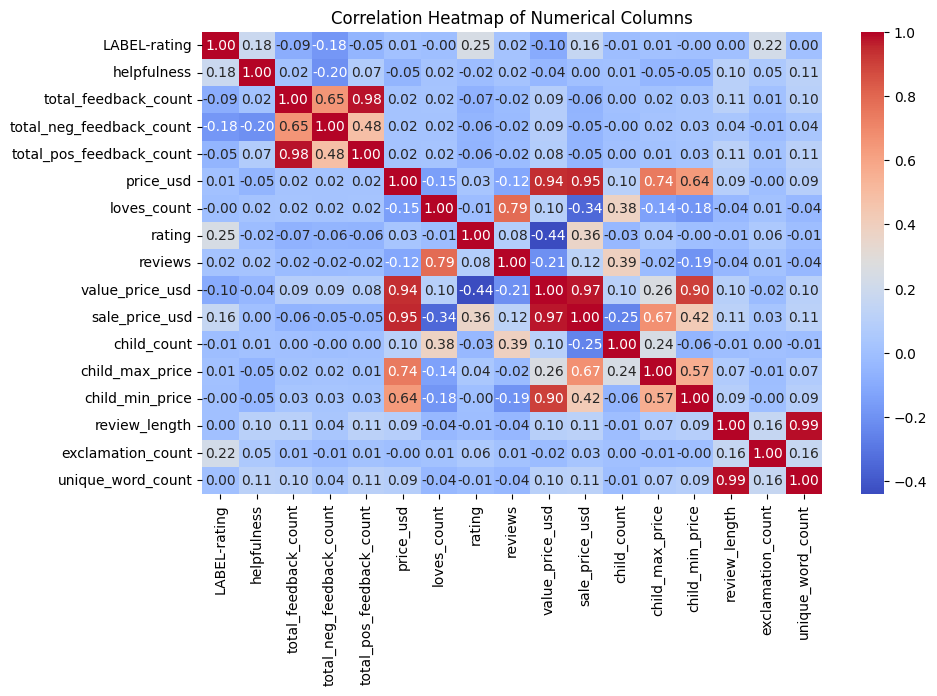

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Columns")
plt.show()

**- czy któraś z cech koreluje ze zmienną wyjściową? Jeśli tak - która? Czy któraś nie koreluje?**

Koreluje: rating, expclamation_count, helpfulness, total_neg_feedback_count oraz sale_price_usd.

Nie koreluje: new, reviews, online_only, child_max_price, child_count, out_of_sstock, sephora_exclusive, price_usd, review_lengst, loves_count, limited_edition, child_min_price, unique_word_count.

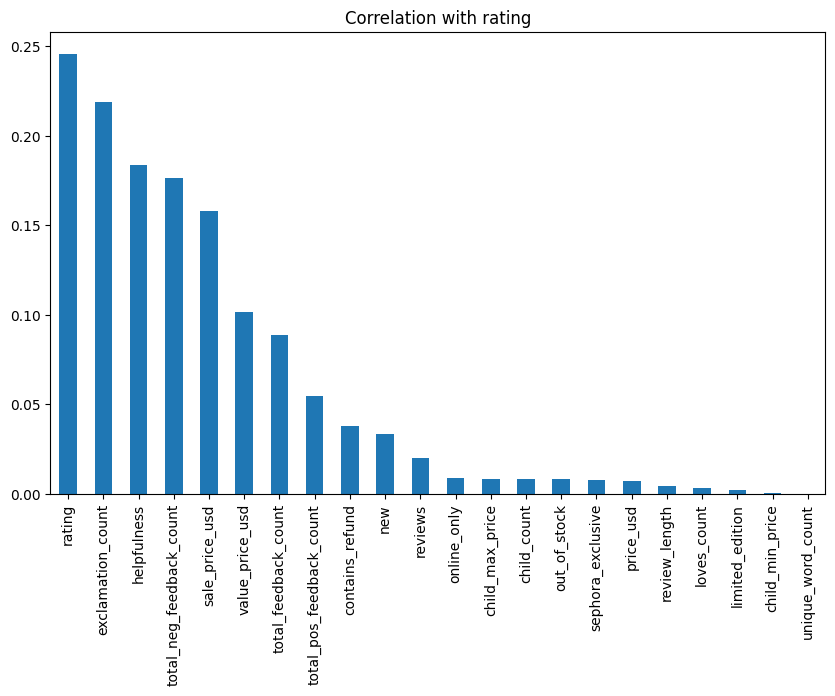

In [8]:
correlation = df[cath_cols + num_cols].corr().abs()
correlation_label = correlation["LABEL-rating"].drop("LABEL-rating")

plt.figure(figsize=(10, 6))
correlation_label.sort_values(ascending=False).plot(kind="bar")
plt.title("Correlation with rating")
plt.show()

### Dane tekstowe

In [9]:
text_cols = df.select_dtypes(include=["object"]).columns.values

**- czy któreś ze słów wydają się dominować w zbiorze?**

Dominującymi słowami są "skin", "product", "love", "use", "like", "face", "using", "really"

In [10]:
def clean_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", str(text))
    text = text.lower()
    return text

In [11]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))
df["cleaned_text"] = df["review_text"].apply(clean_text)
df["cleaned_text_tokens"] = df["cleaned_text"].apply(
    lambda x: [word for word in x.split() if word not in stop_words]
)
all_words = [word for tokens in df["cleaned_text_tokens"] for word in tokens]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
word_counts = Counter(all_words)
word_freq_df = pd.DataFrame(word_counts.items(), columns=["word", "count"]).sort_values(
    by="count", ascending=False
)

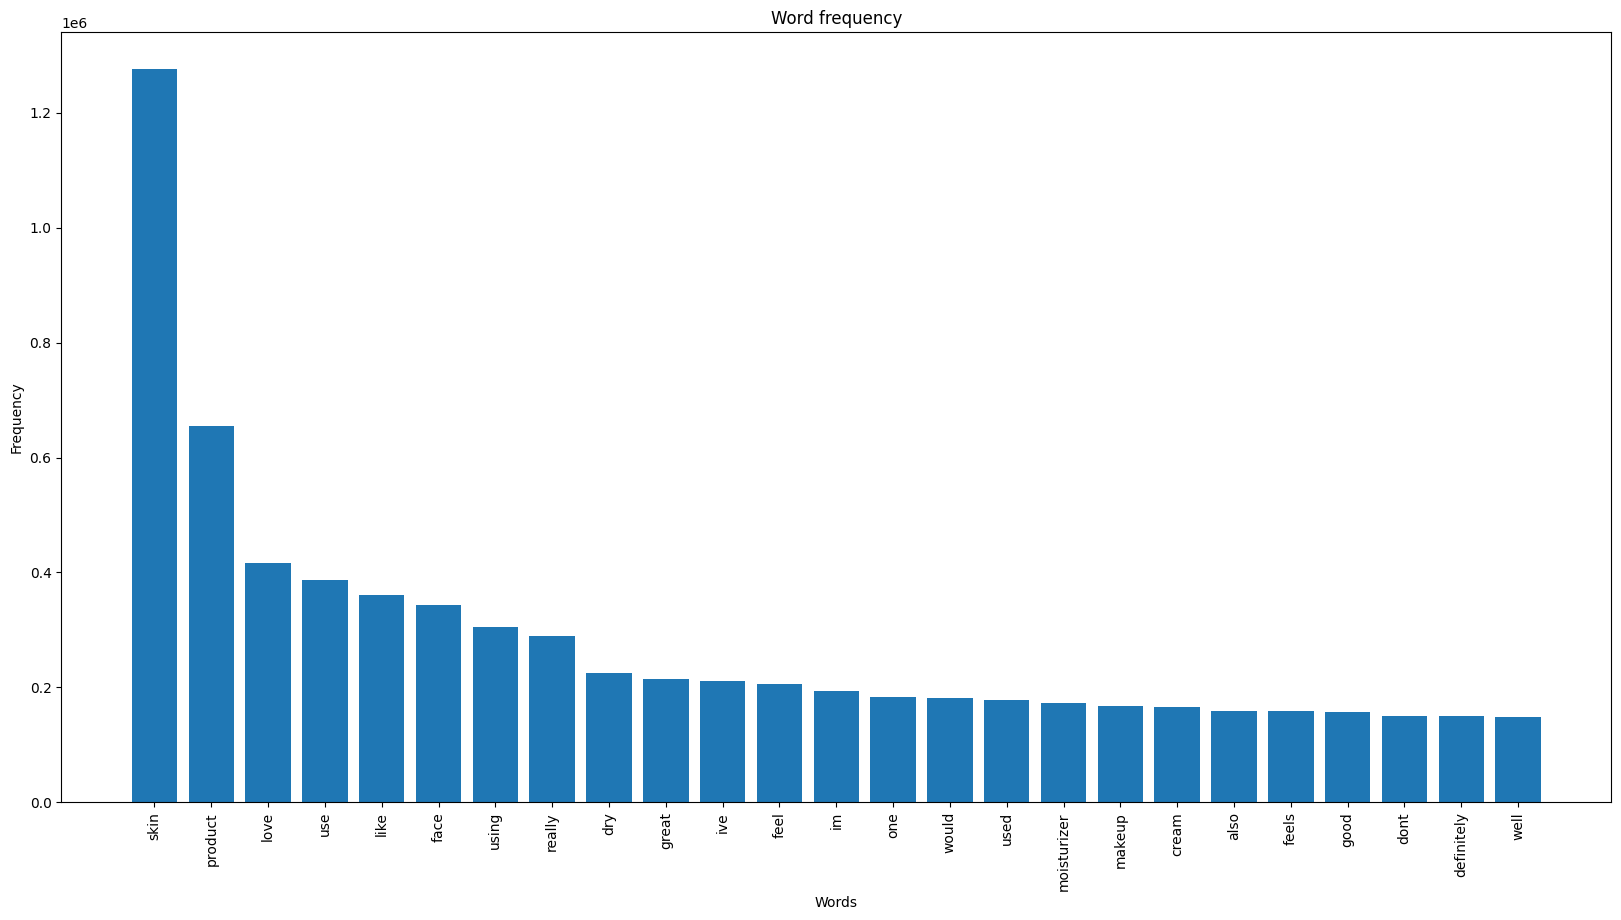

In [13]:
plt.figure(figsize=(20, 10))
plt.bar(word_freq_df["word"][0:25], word_freq_df["count"][0:25])
plt.xticks(rotation=90)
plt.title("Word frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

**- czy najpopularniejsze słowa różnią się znacząco pomiędzy klasami? Czy potrafisz wyróżnić słowa mogące wpływać w znaczym stopniu na sentyment?**

Najpopularniejsze słowa nieznacznie różnią się pomiędzy klasami.

3 pierwsze wyrazy dla rating 1-4 to "skin", 'product' oraz 'like'.

Dla ratingu 5 to "skin", 'product' oraz 'love'.

Charakterystycznymi wyrazami dla klasy 1 oraz 2 są: **get**, **didn't**, **don't**, **even**, **tried**, **made**

Dla klasy 3 są **think**, **nice**

Dla klasy 4 oraz 5 są **great**, **amazing**, **moisturizer**, **cream**, **makeup**

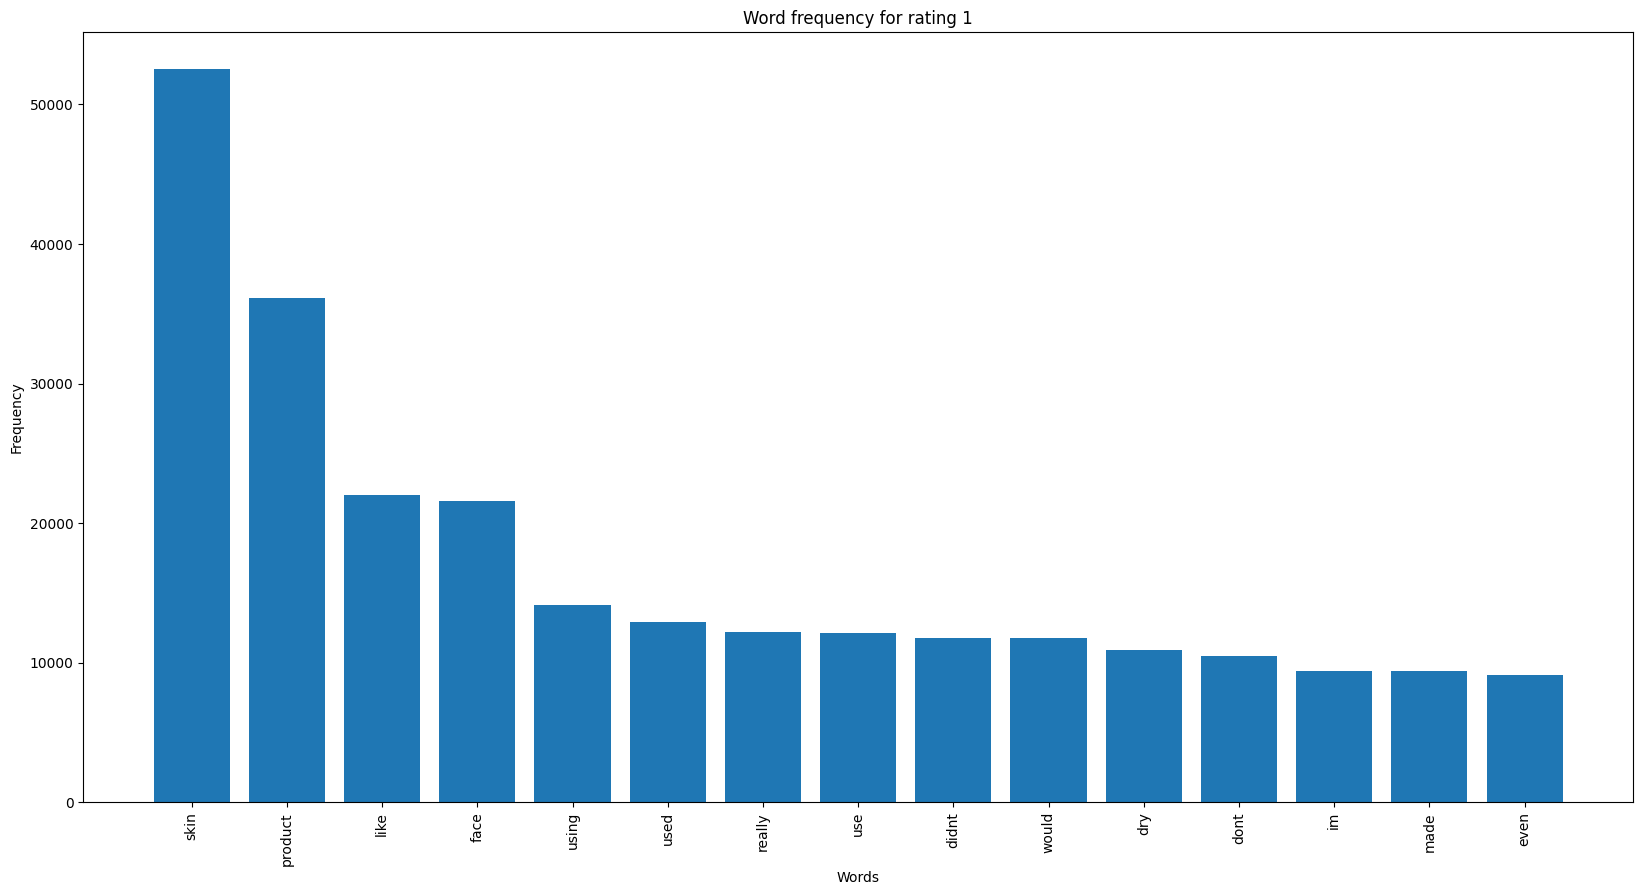

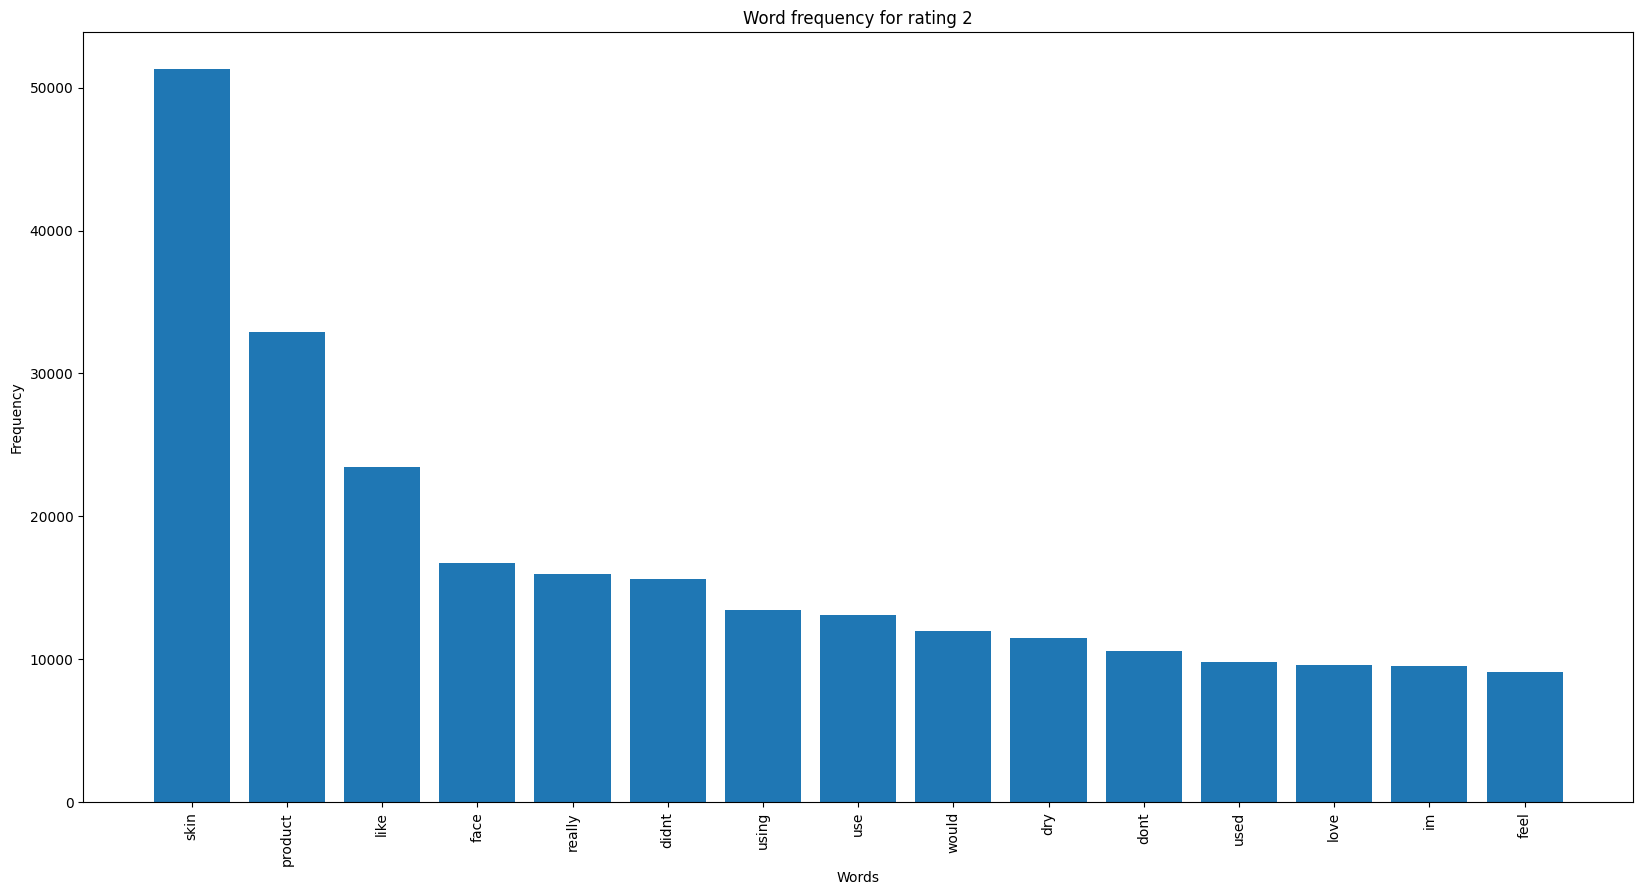

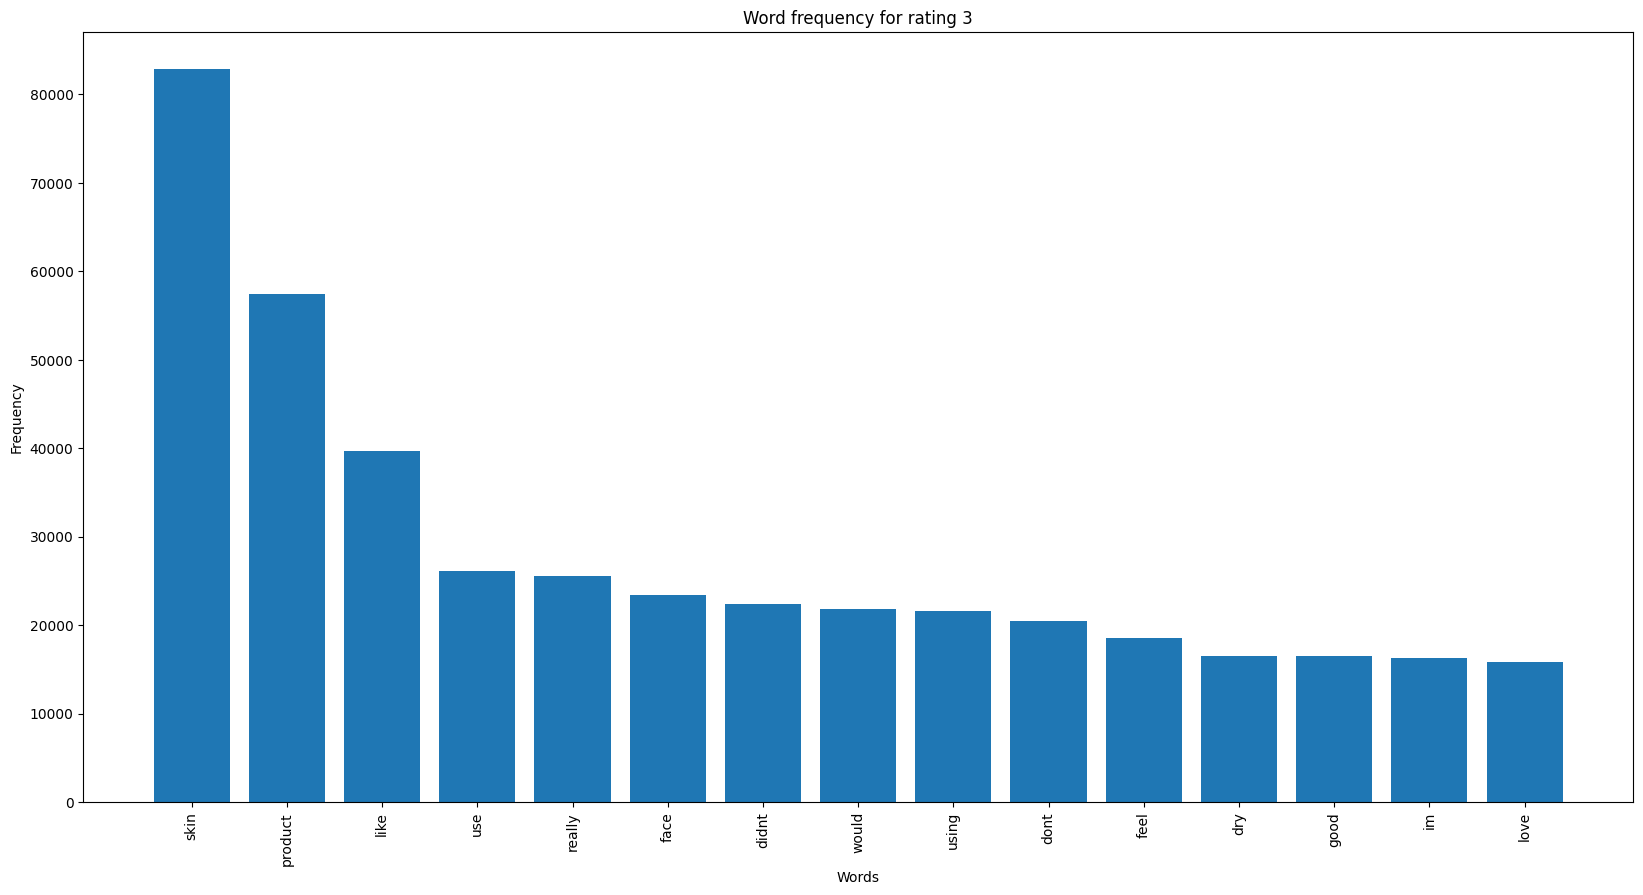

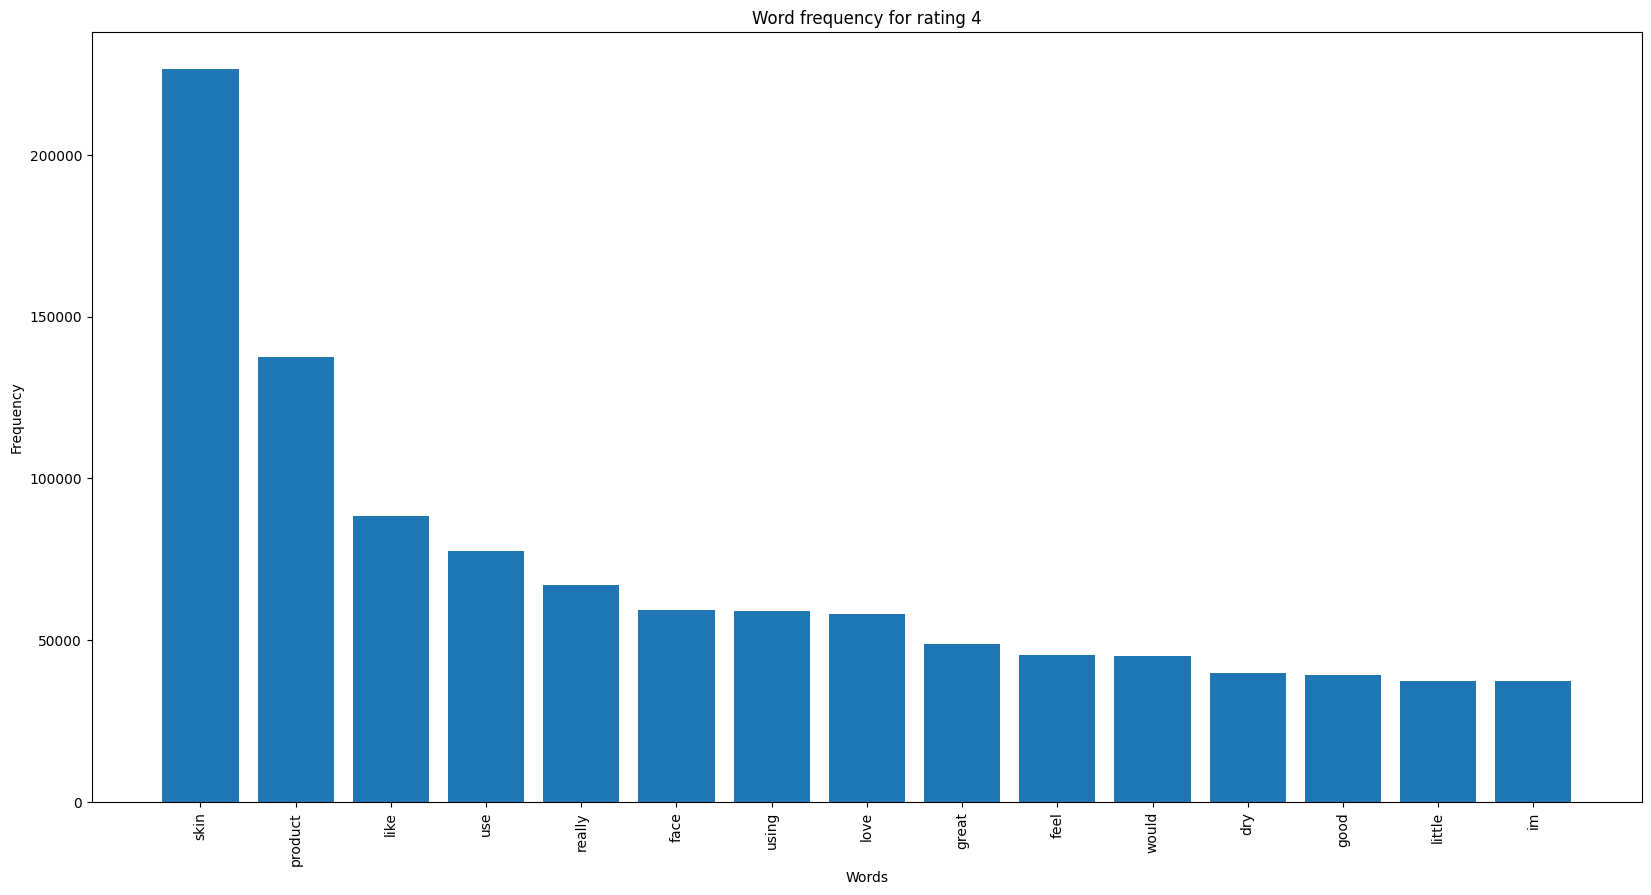

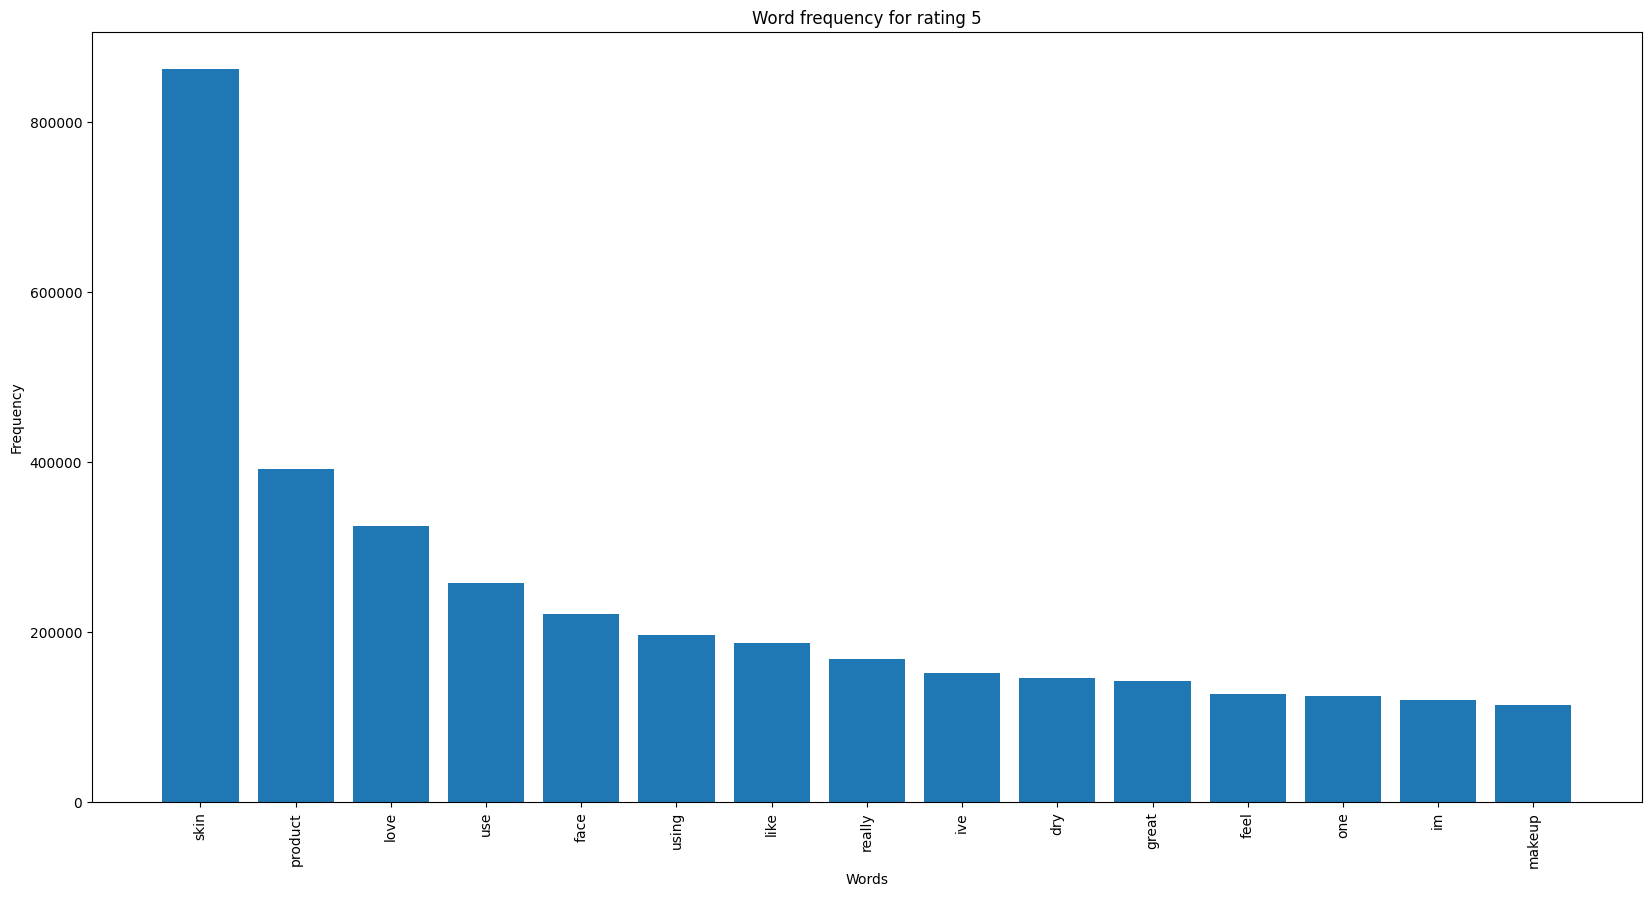

In [14]:
for i in range(1, 6):
    filtered_df = df[df["LABEL-rating"] == i]
    all_words = [
        word for tokens in filtered_df["cleaned_text_tokens"] for word in tokens
    ]
    word_counts = Counter(all_words)
    word_freq_df = pd.DataFrame(
        word_counts.items(), columns=["word", "count"]
    ).sort_values(by="count", ascending=False)
    plt.figure(figsize=(20, 10))
    plt.bar(word_freq_df["word"][0:15], word_freq_df["count"][0:15])
    plt.xticks(rotation=90)
    plt.title(f"Word frequency for rating {i}")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.show()

### Dodatkowe pytania

**- jaka jest charakterystyka tekstu (np. długość, czystość)? (opisane w dodatkowych pytaniach)**

Zazwyczaj recenzje posiadają 320 znaków, ponad 5 zdań, 45 unikatowych wyrazów oraz 0.7 wykrzyknika.

Największą różnice można odnotować w liczbie wykrzykników dla reviews o ocenie 5, gdzie wartośc wynosi 1.2 wykrzyknika na ocenę, im niższa ocena tym mniej wykrzykników.

Statystycznie im więcej zdań tym lepsza ocena.

w kwestii unikatowych wyrazów oraz długości recenzji dla rating 1-4 im więcej wyrazów i im dłuższa recenzja tym wyższy rating, lecz zależnośc nie jest prawdziwa dla rating = 5.

In [15]:
text_data = []

for i in range(1, 6):
    filtered_df = df[df["LABEL-rating"] == i]

    text_data.append(
        {
            "avg length": filtered_df["review_length"].mean(),
            "avg sentence count": filtered_df["review_text"]
            .str.split(r"[.!?]")
            .str.len()
            .mean(),
            "avg unique word count": filtered_df["unique_word_count"].mean(),
            "avg exclamation count": filtered_df["exclamation_count"].mean(),
        }
    )

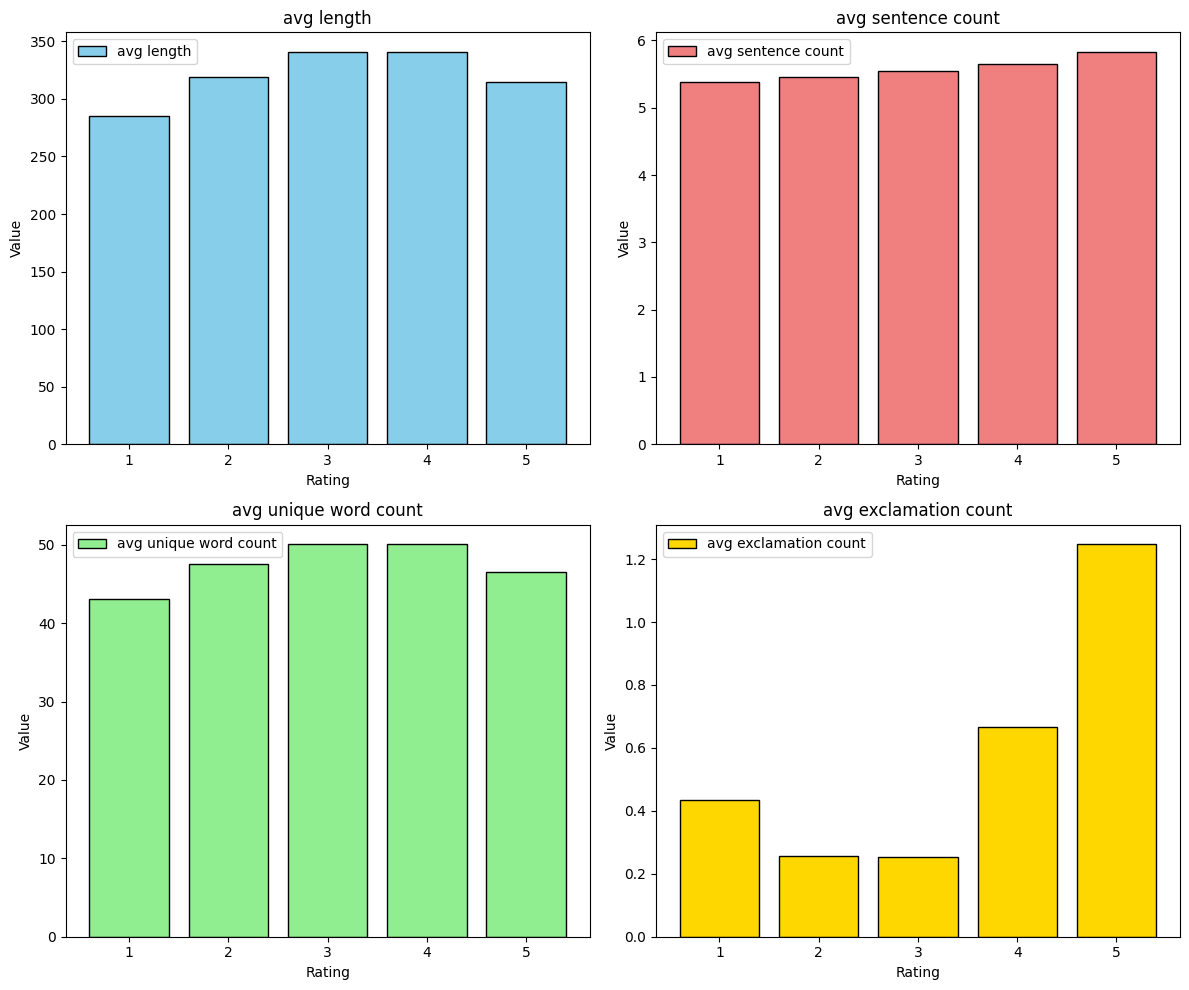

In [16]:
categories = [
    "avg length",
    "avg sentence count",
    "avg unique word count",
    "avg exclamation count",
]
ratings = [1, 2, 3, 4, 5]
colors = ["skyblue", "lightcoral", "lightgreen", "gold"]

values = {category: [entry[category] for entry in text_data] for category in categories}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, category, color in zip(axes.flatten(), categories, colors):
    bars = ax.bar(
        ratings, values[category], color=color, edgecolor="black", label=category
    )

    ax.set_title(category)
    ax.set_xlabel("Rating")
    ax.set_ylabel("Value")
    ax.set_xticks(ratings)
    ax.legend()

plt.tight_layout()
plt.show()

**Czy rozkład klas w zmiennej wyjściowej (LABEL-rating) jest zrównoważony?**

Istnieje nierównomierny rozkład klas - klasa 5 posiada prawie 700_000 reprezentantów, gdzie klasy 1 oraz 2 posiadają po 50_000 reprezentatnów

<Axes: xlabel='LABEL-rating'>

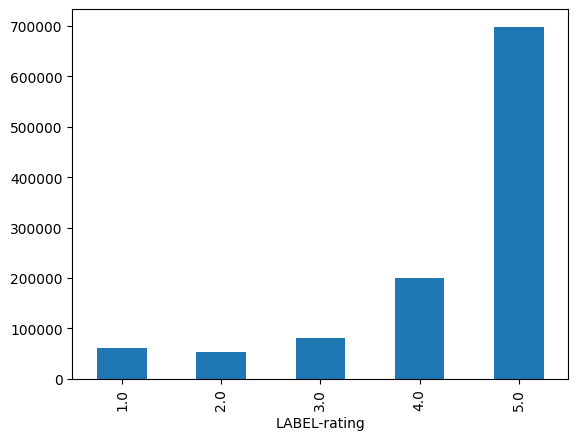

In [17]:
df["LABEL-rating"].value_counts().sort_index().plot(kind="bar")

**Czy są duplikaty w zbiorze danych?**

Tak, istanieje 925 duplikatów.

In [18]:
# df.duplicated().sum()

### Ciekawe spostrzeżenia

1. Zaobserwowano, iż niektóre kolumny mają nieprawidłowy typ object zamiast int64. Zdecydowano się naprawić typy w skrycpie process_data.py
2. Zaobserwowano wiele brakujących wartości, może warto je uzupełnić bądź usunąć rekordy z brakującymi wartościami
3. Wykrzykniki fenomentalnie określają czy opinia będzie miała wysoką ocenę
4. Najczęstsze wyrazy  dla poszczególnych ratingów są bardzo intuicyjne. Niskie wartości - didin't, don't. Średnie wartości - like. Wysokie wartości - love, amazing.

### Rekomendowane dalsze kroki

- Warto dodać metrykę liczącą wykrzykniki w wypowiedzi.
- Warto poprawić typ danych dla odpowiednich kolumn
- Warto uzupełnić brakujące wartości
- Warto zastanowić się nad zwiększeniem liczebności klas o niskim ratingu
- Warto usunąć duplikaty